# Coursework 2

## Load Data
* File is 500mb, load once

In [1]:
# Utils

from tqdm import tqdm_notebook # Progress bar

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import json
from scipy.io import loadmat

### Load Features

In [3]:
with open( "PR_data/feature_data.json", "r" ) as file:
    features = json.load( file )
    
data = np.asarray( features )

print( 'Data shape: {}'.format( data.shape ) )

Data shape: (14096, 2048)


### Load Image Annotations

From the file **cuhk03_new_protocol_config_labeled.mat**

There are 6 main components of this file:

1. camId specidies whether image was taken from camera 1 or camera 2. While evaluating your algorithms, you should not consider images of your current query identity taken from the same camera. For example, when you create ranklist for the first query image (index 22, label 3, camera 1, name "1_003_1_02.png"), you should not include images with indexes 21, 23, 24 in this ranking list
2. filelist
3. gallery_idx, which specifies indexes of the part of the dataset from which you compose your ranklists during testing phase
4. labels contains ground truths for each image
5. query_idx contains indexes of query images
6. train_idx contains indexes of images that can be used for training

In [4]:
# Load matfile
mat = loadmat( 'PR_data/cuhk03_new_protocol_config_labeled.mat' )

In [5]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'camId', 'filelist', 'labels', 'query_idx', 'gallery_idx', 'train_idx'])

In [6]:
# Load labels
labels = mat[ 'labels' ].flatten()

# Load camId
camIds = mat[ 'camId' ].flatten()

# Load indexes
train_idxs   = mat[ 'train_idx' ].flatten()
query_idxs    = mat[ 'query_idx' ].flatten()
gallery_idxs = mat[ 'gallery_idx' ].flatten()

# Load training indexes
print( "Loading Training indexes : {}".format( train_idxs.shape ) )
print( "Loading Query indexes : {}".format( query_idxs.shape ) )
print( "Loading Gallery indexes : {}".format( gallery_idxs.shape ) )

Loading Training indexes : (7368,)
Loading Query indexes : (1400,)
Loading Gallery indexes : (5328,)


In [7]:
# Create Train Set
train_set   = []
train_label = []

for i in train_idxs:
    train_set.append( data[ i - 1 ] )
    train_label.append( labels[ i - 1 ] )
    
train_set   = np.asarray( train_set )
train_label = np.asarray( train_label )

print( 'Train Set : {}'.format( train_set.shape ) )
print( 'Train Label : {}'.format( train_label.shape ) )


# Create Query Set
query_set   = []
query_label = []
query_camId = []

for i in query_idxs:
    query_set.append( data[ i - 1] )
    query_label.append( labels[ i - 1 ] )
    query_camId.append( camIds[ i - 1 ] )
    
query_set   = np.asarray( query_set )
query_label = np.asarray( query_label )
query_camId = np.asarray( query_camId )

print( '\nQuery Set : {}'.format( query_set.shape ) )
print( 'Query Label : {}'.format( query_label.shape ) )
print( 'Query CamId : {}'.format( query_camId.shape ) )


# Create Gallery Set
gallery_set   = []
gallery_label = []
gallery_camId = []

for i in gallery_idxs:
    gallery_set.append( data[ i - 1] )
    gallery_label.append( labels[ i - 1 ] )
    gallery_camId.append( camIds[ i - 1 ] )
    
gallery_set   = np.asarray( gallery_set )
gallery_label = np.asarray( gallery_label )
gallery_camId = np.asarray( gallery_camId )

print( '\nGallery Set : {}'.format( gallery_set.shape ) )
print( 'Gallery Label : {}'.format( gallery_label.shape ) )
print( 'Gallery CamId : {}'.format( gallery_camId.shape ) )

Train Set : (7368, 2048)
Train Label : (7368,)

Query Set : (1400, 2048)
Query Label : (1400,)
Query CamId : (1400,)

Gallery Set : (5328, 2048)
Gallery Label : (5328,)
Gallery CamId : (5328,)


____

## Create Augmented Query and Gallery Sets

In [8]:
# Query Augmented
qs = query_set.T

query_augmented = np.vstack( ( qs, query_camId, query_label ) )
query_augmented = query_augmented.T

# Gallery Augmented
gs = gallery_set.T

gallery_augmented = np.vstack( ( gs, gallery_camId, gallery_label ) )
gallery_augmented = gallery_augmented.T

print( 'Query Augmented: {}'.format( query_augmented.shape ) )
print( 'Gallery Augmented: {}'.format( gallery_augmented.shape ) )

Query Augmented: (1400, 2050)
Gallery Augmented: (5328, 2050)


In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

In [277]:
%%time

# KNN Parameters
knn_n_neighbors = 20
knn_metric = 'euclidean'


query_rank_list = []

# for i in range( 2,4 ):
for i in tqdm_notebook( range( query_augmented.shape[ 0 ] ) ):

    
    query_label = query_augmented[ i, -1 ].astype( int )

    # Remove rows which have the same camId AND label
    gallery_reduced = gallery_augmented[ ~np.logical_and( ( gallery_augmented[ :, -1 ] == query_augmented[ i ][ -1 ] ),
                                                          ( gallery_augmented[ :, -2 ] == query_augmented[ i ][ -2 ] )
                                      ) ]
    
    # Train KNN
    X = gallery_reduced[ :, : - 2 ] # All rows, but in each row, remove last 2 columns ( camId and label )
    Y = gallery_reduced[ :, - 1 ] # All rows in the last column ( the labels )
    
    KNN = NearestNeighbors( n_neighbors = knn_n_neighbors, metric = knn_metric )
    KNN.fit( X, Y )    
    
    # Test query point
    X_test = query_augmented[ i ][ : -2 ].reshape( 1, -1 ) # Remove last 2 columns ( camId and label )
    
    distances, indices = KNN.kneighbors( X_test ) # Neighbours are ordered closest to furthest
    
    # Compare
    distances = distances.flatten()
    indices   = indices.flatten()
    
    rank_list = [ gallery_reduced[ ind, -1 ].astype( int ) == query_label for ind in indices ]
    query_rank_list.append( rank_list )
    
    #count += ( gallery_reduced[ indices[ 0 ], -1 ].astype( int ) == query_augmented[ i, -1 ].astype( int ) )  
    
query_rank_list = np.asarray( query_rank_list )


CPU times: user 19min 10s, sys: 1min 13s, total: 20min 23s
Wall time: 20min 22s


In [10]:
query_rank_list = query_rank_list.astype( int )

# Save as CSV so we dont have to fucking run that 20 minute code anymore
np.savetxt( 'query_rank_list.csv', query_rank_list, fmt='%i', delimiter= ',' )

NameError: name 'query_rank_list' is not defined

In [10]:
# Load csv file
query_rank_list = np.loadtxt( 'query_rank_list.csv', delimiter = ',' )

query_rank_list.shape

(1400, 20)

### CMC
https://www.reddit.com/r/computervision/comments/10oc4x/need_help_understanding_cumulative_match_score/

In [11]:
rankAt1  = query_rank_list.T[ 0 ]
rankAt5  = query_rank_list.T[ : 5 ].T
rankAt10 = query_rank_list.T[ : 10 ].T

cmc1  = rankAt1
cmc5  = np.sum( rankAt5, axis = 1 ) > 0 # Dirty python trick: sum across rows, if sum > 0, set to 1
cmc10 = np.sum( rankAt10, axis = 1 ) > 0

print( 'rank@1: {}%'.format( np.sum( cmc1 ) / cmc1.shape[ 0 ] * 100 ) )
print( 'rank@5: {}%'.format( np.sum( cmc5 ) / cmc5.shape[ 0 ] * 100 ) )
print( 'rank@10: {}%'.format( np.sum( cmc10 ) / cmc10.shape[ 0 ] * 100 ) )

rank@1: 47.0%
rank@5: 66.85714285714286%
rank@10: 74.92857142857143%


### mAP

[Calculating mAP](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173)

In [13]:
unique, counts = np.unique( train_label, return_counts = True )

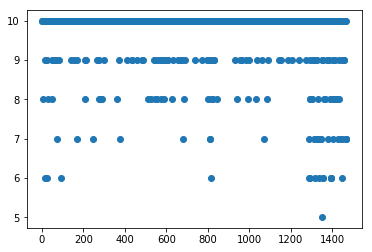

In [15]:
plt.scatter( unique, counts )